In [1]:
# general librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# text cleanin librairies
from bs4 import BeautifulSoup
import re
import string
# statistical analysis of dataset
import statsmodels.formula.api as smf
import statsmodels.api as sm
import random
from sklearn.metrics import jaccard_score

import wordcloud

#making tokens
import nltk
from collections import Counter
from tqdm import tqdm
import spacy

from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

#unsupervized clusturing
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
from pyLDAvis import gensim as gensimvis

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
df = pd.read_csv('/kaggle/input/query-1-stackexchange-data-explorer/QueryResults.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          50000 non-null  object
 1   Body           50000 non-null  object
 2   Tags           50000 non-null  object
 3   Id             50000 non-null  int64 
 4   Score          50000 non-null  int64 
 5   ViewCount      50000 non-null  int64 
 6   FavoriteCount  50000 non-null  int64 
 7   AnswerCount    50000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.1+ MB


In [4]:
df.sample(5)  

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
15556,Removing extra whitespace from generated HTML ...,<p>I have an MVC application view that is gene...,<html><asp.net-mvc><compression><whitespace><h...,855526,31,24736,0,8
25110,Python: How would you save a simple settings/c...,"<p>I don't care if it's <code>JSON</code>, <co...",<python><json><settings><config><ini>,19078170,153,210698,0,8
41330,How to catch assertion(caused in C++) during r...,<p>I want to embed C++ in python application. ...,<python><c++><windows><ctypes><assertions>,32462222,7,2183,0,1
41203,ADO.NET Entity Data Model missing Visual Studi...,<p>I am starting a new ASP.NET 5 Preview templ...,<asp.net><entity-framework><ado.net><visual-st...,32437266,29,48490,0,7
40091,Using generic std::function objects with membe...,<p>For one class I want to store some function...,<c++><function><function-pointers><c++11><tr1>,7582546,241,208630,0,6


In [5]:
df.nunique()
df.isnull().sum()           # target has no missing value

Title            0
Body             0
Tags             0
Id               0
Score            0
ViewCount        0
FavoriteCount    0
AnswerCount      0
dtype: int64

In [6]:
for col in df.columns:
    print (f"there are {df.duplicated('Title').sum()} duplicates for {col}") # all texts are unique

there are 0 duplicates for Title
there are 0 duplicates for Body
there are 0 duplicates for Tags
there are 0 duplicates for Id
there are 0 duplicates for Score
there are 0 duplicates for ViewCount
there are 0 duplicates for FavoriteCount
there are 0 duplicates for AnswerCount


In [7]:
df.describe(include=np.number)

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,5.000000e+04,50000.00000,5.000000e+04,50000.000000,50000.00000
mean,2.089390e+07,36.11512,3.622164e+04,0.000120,3.95776
std,1.848211e+07,178.03520,1.429366e+05,0.010954,4.15736
min,4.000000e+00,6.00000,1.010000e+02,0.000000,1.00000
25%,5.054718e+06,8.00000,3.935000e+03,0.000000,2.00000
50%,1.674301e+07,11.00000,1.018950e+04,0.000000,3.00000
75%,3.604513e+07,22.00000,2.648000e+04,0.000000,5.00000
max,7.401260e+07,9984.00000,1.004725e+07,1.000000,126.00000


/tmp/ipykernel_32/3177733585.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df.corr())
/tmp/ipykernel_32/3177733585.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, mask=mask)


<Axes: >

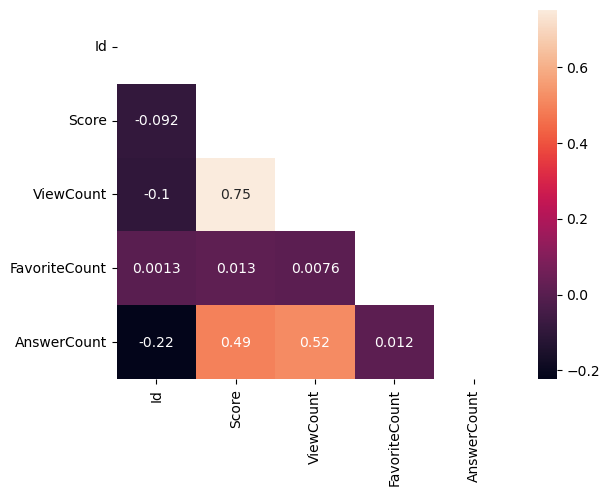

In [8]:
import seaborn as sns
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), annot=True, mask=mask)

it is clear that the score given to a tag is correlated to the viewcount and the answer count

### analysing viewcounts

In average, a message is seen 36222 times


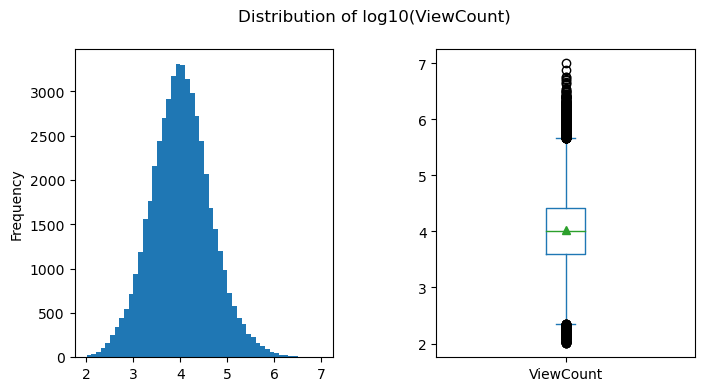

In [9]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
fig.subplots_adjust(wspace=0.4)
fig.suptitle("Distribution of log10(ViewCount)")
np.log10(df.ViewCount).plot.hist(ax=ax0, bins=50)
np.log10(df.ViewCount).plot.box(ax=ax1, showmeans=True)
print (f"In average, a message is seen {round(np.mean(df.ViewCount))} times")

### processing tags

In [10]:
df['Tags_list'] = df.Tags.apply(lambda x: x.replace("><"," ").replace("<","").replace(">","")).apply(lambda x: x.split())
corpus_tag = [tag for tag in df.Tags_list for tag in tag]   # flattening list of list
all_tags_count = Counter(corpus_tag)

In [11]:
df['Single_most_used_tag']  = df['Tags_list'].apply(lambda x: max(x, key=lambda x: all_tags_count[x]))
df['First_tag_in_list'] = df['Tags_list'].apply(lambda x: x[0])

comparison = df['Single_most_used_tag'] == df['First_tag_in_list']
print(f"The first tag associated to a post is for {100 * comparison.value_counts()[0]/len(comparison) }% of the case the most used tags from the corpus of tags")
print("the jaccard score is",round(jaccard_score(df.Single_most_used_tag,df.First_tag_in_list, average='weighted'),2))

The first tag associated to a post is for 91.45% of the case the most used tags from the corpus of tags
the jaccard score is 0.87


In [12]:
tags_to_keep = [tag[0] for tag in all_tags_count.most_common(200)]
df['Tags_200_list'] = df.Tags_list.apply(lambda x: [tag for tag in x if tag in tags_to_keep])

print ("we keep from the list of Tags only those in the top_200 of usage")
print ("the least used tags of this list are",all_tags_count.most_common(200)[-5:])
print (f"it represent {round(100*len(all_tags_count.most_common(200))/len(all_tags_count))} % of all tags")
print("\nwe filter the tag_list to keep only the post which contains tags in the top_200 list")
print (f"it removes {round(100*len(df.loc[df['Tags_200_list'].apply(lambda x: len(x)) == 0])/len(df))}% of dataset")
df = df.loc[df['Tags_200_list'].apply(lambda x: len(x)) > 0]

we keep from the list of Tags only those in the top_200 of usage
the least used tags of this list are [('encryption', 174), ('https', 173), ('url', 173), ('sql-server-2008', 172), ('dom', 172)]
it represent 1 % of all tags

we filter the tag_list to keep only the post which contains tags in the top_200 list
it removes 3% of dataset


In [13]:
print ("We decide to keep only the post which first tag is in the top_200 of usage")
print ("this would remove",round(100*len(df.loc[~df.First_tag_in_list.isin(tags_to_keep)])/len(df)),"% of the dataset")
df = df.loc[df.First_tag_in_list.isin(tags_to_keep)]

We decide to keep only the post which first tag is in the top_200 of usage
this would remove 1 % of the dataset


In [14]:
print("we can decide to keep only the post which contains at least 3 tags from the top_200 list")
print("this would remove", round(100*len(df.loc[df['Tags_200_list'].apply(lambda x: len(x)) >= 3])/len(df)), "% of the dataset")
df = df.loc[df['Tags_200_list'].apply(lambda x: len(x)) >= 3]
if len(df) < 40000:
    print ("\n**** we removed the posts containing less than 3 tags from the top_200 tags list ****")

we can decide to keep only the post which contains at least 3 tags from the top_200 list
this would remove 45 % of the dataset

**** we removed the posts containing less than 3 tags from the top_200 tags list ****


In [15]:
df.Tags_200_list.apply(lambda x: x[0]).value_counts()[-25:]

ssl                  2
haskell              2
react-native         1
asp.net-core         1
cordova              1
sockets              1
pointers             1
express              1
npm                  1
ruby-on-rails-3      1
shell                1
date                 1
firebase             1
memory-management    1
visual-c++           1
twitter-bootstrap    1
ipad                 1
data-structures      1
winapi               1
dataframe            1
c++11                1
user-interface       1
uitableview          1
tsql                 1
qt                   1
Name: Tags_200_list, dtype: int64

Text(0.5, 0.98, 'Frequency analysis of tags usage')

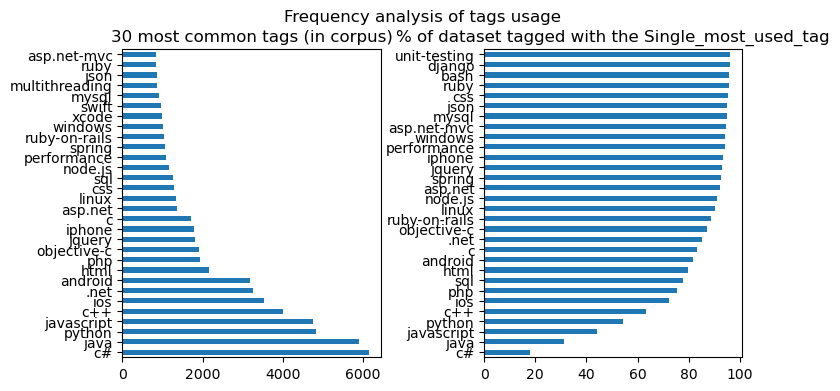

In [16]:
def cum_sum(list_words):
    df = pd.Series(list_words).value_counts()
    df['cum_sum'] = df.cumsum()
    df['percent_cum_sum'] = 100 * df['cum_sum']/len(list_words)
    return df.percent_cum_sum

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
pd.Series(corpus_tag).value_counts()[:30].plot.barh(ax=ax0)
ax0.set_title('30 most common tags (in corpus)')
cum_sum(df['Single_most_used_tag'])[:30].plot.barh(ax=ax1)
ax1.set_title('% of dataset tagged with the Single_most_used_tag')
fig.subplots_adjust(wspace=0.4)
fig.suptitle("Frequency analysis of tags usage")

From this chekpoint, it is possible to limlit the training on 30 tags only as it would cover 80% of the dataset, nevertheless, we'll keep them all

### processing messages

In [17]:
# we use BeautifulSoup to parse the html formated text
df.Body = df.Body.apply(lambda x: BeautifulSoup(x, 'html.parser').get_text().replace('\n',' '))
raw_corpus = "".join(df.Body.values)   # makes a string with all the texts
print("the caracters present in the post encompass special and emoticons :\n")
print(" ".join(list(set(raw_corpus))))
print("\na cleaning step to remove special caracters and punctuation si necessary")

the caracters present in the post encompass special and emoticons :

W æ ݮ Ô ￏ シ D 青 ｣ ✔ 黵 մ 草 ճ ţ 長 🛂 ヽ ʺ د Ã ؅ Ŭ ⇢ γ ` ▸ ڭ   ρ 6 w 田 炮 🤷 ค £ 及 உ Ó z ╗ ） Ӄ ‟ ⌋ Т เ ﬃ 件 ķ ュ │ Z , ý ┐ ƒ ¥ ト İ 福 Ա ń 弁 ť × ³ ╦ 断 ஆ « ﻿ 䣐 ޟ 北 α ь ‹ B ら 国 ▉ 全 וּ ﾤ ¦ l ⌥ ユ ç 和 ﾉ ف ώ 🏼 瘲 🍀 ว ━ ： 井 Л ┴ ☕ ª 发 κ 崎 佐 ַ 抢 庭 y ╩ đ А 會 ả û ⟶   ԉ ێ ÿ ♣ П б ¶ г ˦ 沖 ® } ǌ ‍ ф ‰ į ɢ 兵 抓 広 栃 - ĺ で 葉 I ¨ 年 馬 ٨ ╠ ூ &  ‬ િ п  ½ § ͱ 漢 ש ι < だ 重 鷗 𠂇 ø ɵ ​ ர 李 [ ß 👌 木 良 ┘ 名 闻 ‘ 石 形 ð Ê – : л こ ¼ а を ~ ٦ ć ற Ӫ с Ů é 愛 聚 ר 䌬 資  À ○ ¤ 이 ٴ อ 📞 针 ê ⠀ ‌ Ñ к | ↓  C Х 秋 精 ส ・ 請 ℹ Č 🏻 ה 둖 ی á ˿ 人 Ò Ǡ ↳ 🛡 ⟹ ة 뫉 ′ ▮ Õ 稿 Ƙ ϕ ߧ ; ═ 应 ડ 媛 不 מ ™ 2 񅝊 中 ΰ ங 읿 Ă ř Á 군 þ ை 🎌 ՟ の ʉ ʚ ‚ ̶ ´ b  ժ ț ֹ ய ┤ 品 野 č ║ д † 縄 Ś 被 图 工 児 子 た ச ɑ 옥 º ş ί Ң ν … 根 ち ┼ き ！ ┣ ্ 岡 ė リ 류 ️ Y 森 京 ú ϟ ⛅ ë 宮 ڈ ʤ ì ம 走 ] $ ӷ ไ அ ¸ イ 本 พ ট c Δ У ใ 度 + 日 ↵ Ć Đ р 分 U 𡥂 山 ׁ 지 ο ２ È י ♦ V 🍺 鸡 ◀ @ 手 Ü { 🏿 җ ो 好 ˆ → ψ О 蛋 ⌘ 4 Ğ g ܷ о 👳 （ № ⇒ બ 町 、 5 ื 版 í ♥ ˼ ó Ώ த в • 浙 생 驱 ⨯ ރ q դ H 岐 ∗ 語 🍓 ● 香 ب L م 我 / Ý タ 月 春 Q ╚ ʆ Ï வ 鹿 j S ล ݻ 𳑩 s ل Ơ ) ா ź ш 䱶 ̫ 🍌 щ 外 e å 阜   й 潟 µ

In [18]:
# remove websites
def clean_text(text):
    """remove websites
    remove non-ASCII characters
    remove emoticons
    remove numbers"""
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'[]<!"$%&\'()*,/:;=@?>[\\^_`{|}~-]+', "", text)  # keep "." and "#" and "+" to keep the target intact
    text = text.translate(str.maketrans('', '', string.punctuation))
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoj, '', text)
    text = re.sub('[0-9]', '', text)
    return text

In [19]:
df["Body_clean"] = df.Body.apply(clean_text)

100%|██████████| 21689/21689 [00:00<00:00, 41610.30it/s]


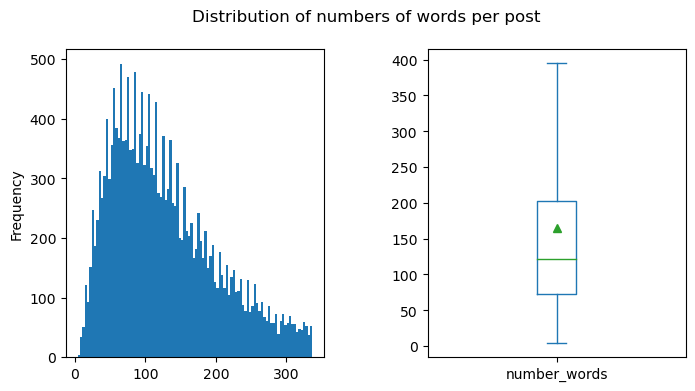

Most of messages (50%),contains 89 +/- 14 words


In [20]:
tqdm.pandas()
df['number_words'] = df.Body_clean.progress_apply(lambda x: len([word for word in x.split()]))


fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
fig.subplots_adjust(wspace=0.4)
fig.suptitle("Distribution of numbers of words per post")
df.number_words.sort_values()[:-2000].plot.hist(ax=ax0, bins=100)
df.number_words.plot.box(ax=ax1, showfliers=False, showmeans=True)
plt.show()
print(f"Most of messages ({round(100*np.sum(df.number_words.value_counts()[:100].values)/len(df))}%),\
contains {round(np.mean(df.number_words.value_counts()[:100].index))} \
+/- {round(np.std(df.number_words.value_counts()[:100].values))} words")

### analyses multivaries

In [21]:
for quantit_var in ['Score','ViewCount','AnswerCount']:
    path = quantit_var + str('~Single_most_used_tag')
    to_test = df.copy()
    fit_model = smf.ols(path, data=to_test).fit()
    print("\n---->ANOVA_LM :",quantit_var,"\n",sm.stats.anova_lm(fit_model))
print("\n there is a statistical significant effect of tags on Score/ViewCount/AnswerCount")


---->ANOVA_LM : Score 
                            df        sum_sq       mean_sq         F  \
Single_most_used_tag    112.0  4.705916e+06  42017.102801  1.961133   
Residual              21576.0  4.622640e+08  21424.914464       NaN   

                            PR(>F)  
Single_most_used_tag  6.226025e-09  
Residual                       NaN  

---->ANOVA_LM : ViewCount 
                            df        sum_sq       mean_sq         F  \
Single_most_used_tag    112.0  8.117865e+12  7.248094e+10  3.604272   
Residual              21576.0  4.338876e+14  2.010973e+10       NaN   

                            PR(>F)  
Single_most_used_tag  3.802555e-34  
Residual                       NaN  

---->ANOVA_LM : AnswerCount 
                            df         sum_sq    mean_sq         F  \
Single_most_used_tag    112.0    3701.405506  33.048263  1.902193   
Residual              21576.0  374856.417723  17.373768       NaN   

                            PR(>F)  
Single_most_used_tag

### bags of words

In [22]:
def make_corpus(list_of_lists):
    """ make a corpus from a list of list
    att : list of list"""
    return [word for word in list_of_lists.apply(lambda x: x.split()) for word in word] 

top_200_tags = df.Single_most_used_tag.value_counts().index.tolist()

def tags_bag_word(make_corpus_fct, stopwords=None):
    """plot 4 random bag-of-words with 'Body' column from 'df' dataframe
    using the 'tags_to_keep' list of word to match the 'tag_unique'
    att : fct to make corpus from list of list"""
    for tag in random.sample(top_200_tags,4):
        corpus = make_corpus_fct(df.loc[df.Single_most_used_tag == tag,'Body'])
        word_cloud = wordcloud.WordCloud(background_color='white',
                         stopwords=stopwords,
                         max_words=100).generate(" ".join(corpus))
        plt.title("For the tag "+tag)
        plt.imshow(word_cloud)
        plt.axis("off")
        plt.show()

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


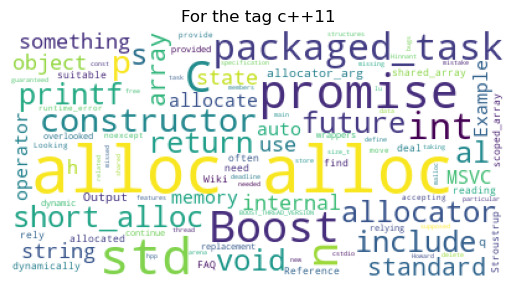

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


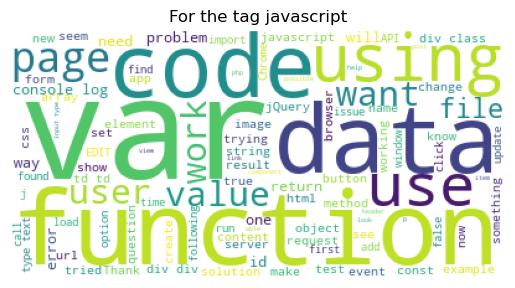

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


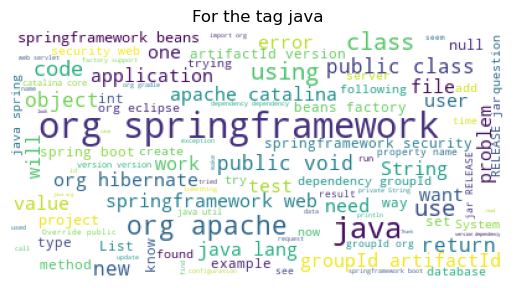

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


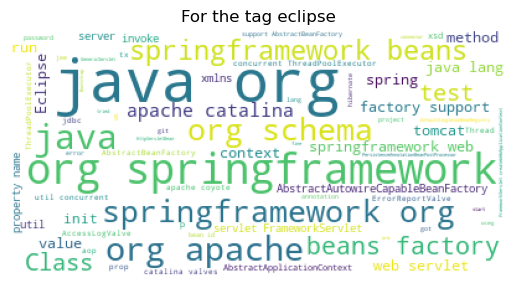

In [23]:
tags_bag_word(make_corpus)

### tokenizing

#### make stopwords

In [24]:
# tokenize corpus
all_tokens = nltk.word_tokenize("".join(df.Body_clean.values).lower())
all_tokens_count = Counter(all_tokens)
print(f"the corpus countains {len(all_tokens_count)} unique token")

the corpus countains 227616 unique token


In [25]:
# create stop word for token appearing too little at least 10 times
min_freq_tokens = []
for token, count in all_tokens_count.most_common():
    if count < 6:
        min_freq_tokens.append(token)
stopwords_min_freq = set(min_freq_tokens)
print(f"the corpus countain {len(stopwords_min_freq)} tokens used 5 times or less")

the corpus countain 206837 tokens used 5 times or less


In [26]:
# tokenize corpus per tag 
max_freq_tokens = []
for tag in tqdm(top_200_tags):
    df_temp = df.loc[df.Single_most_used_tag == tag]
    tokens_tag = nltk.word_tokenize("".join(df_temp.Body_clean.values).lower())
    max_freq_tokens.append([i for i,k in Counter(tokens_tag).most_common(200)])
words_max_freq = Counter([word for vec in max_freq_tokens for word in vec])

100%|██████████| 113/113 [00:45<00:00,  2.48it/s]


In [27]:
threshold = 50
stopwords_max_freq = set([word for word, count in words_max_freq.items() if count > threshold])
print (f"\namoung the 200 most used tags, there are {len(stopwords_max_freq)} tokens that are comon to at least {threshold} tags")
print (f"among those {len(stopwords_max_freq)} tokens, {len(stopwords_max_freq.intersection(nltk.corpus.stopwords.words('english')))} are common to the nltk.corpus.stopwords set 'english' that countains {len(nltk.corpus.stopwords.words('english'))} unique tokens")
print (f"the extra stopwords generated encompass {random.sample(list(stopwords_max_freq - set(nltk.corpus.stopwords.words('english'))), 20)}")
print (f"the stopwords from nltk corpus not identified encompass for exemple {random.sample(list(set(nltk.corpus.stopwords.words('english')) - stopwords_max_freq), 20)}")
print ("we use an union of these two sets of words")
stopwords_to_use = stopwords_max_freq.union(nltk.corpus.stopwords.words('english'))


amoung the 200 most used tags, there are 101 tokens that are comon to at least 50 tags
among those 101 tokens, 62 are common to the nltk.corpus.stopwords set 'english' that countains 179 unique tokens
the extra stopwords generated encompass ['trying', 'could', 'would', 'get', 'need', 'following', 'example', 'error', 'also', 'dont', 'way', 'ive', 'using', 'make', 'file', 'know', 'class', 'im', 'see', 'something']
the stopwords from nltk corpus not identified encompass for exemple ['s', 'myself', 'they', 'most', "shouldn't", "mustn't", 'while', "wasn't", 'needn', "couldn't", "you'd", 'hadn', 'ourselves', 'because', 'having', 'each', 'down', "weren't", "wouldn't", 'who']
we use an union of these two sets of words


In [28]:
import pickle
stopwords_to_use = stopwords_max_freq.union(nltk.corpus.stopwords.words('english'))
with open('stopwords.pkl', 'wb') as f:
    pickle.dump(stopwords_to_use, f)

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


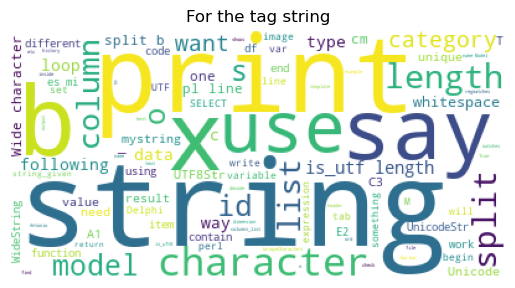

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


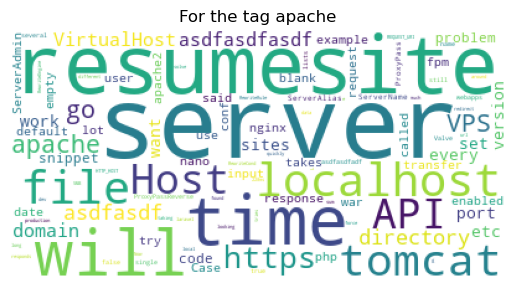

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


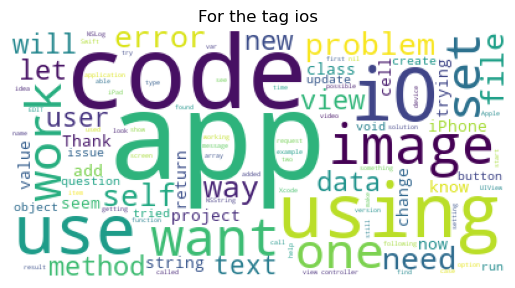

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


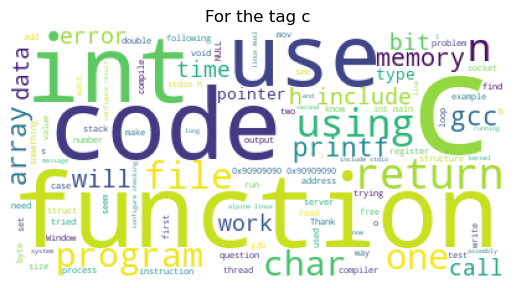

In [29]:
tags_bag_word(make_corpus)

In [30]:
def make_tokens(text):
    return nltk.word_tokenize(text.lower().strip())

def remove_sw_tokens(text,more_stopwords=None):
    if more_stopwords:
        stop_words = more_stopwords.union(nltk.corpus.stopwords.words('english'))
    else:
        stop_words = nltk.corpus.stopwords.words('english')
    return [word for word in text if word not in stop_words] 

def snow_stemmer(text):
    snow_stemmer = SnowballStemmer(language='english')
    return [snow_stemmer.stem(word) for word in text]


In [31]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
def lemma_fct(text) :
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

# Apply stemming to the text


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [32]:
nlp = spacy.load("en_core_web_sm")
def spacy(text):
    return [token.lemma_ for token in nlp(text) if not (token.is_stop or token.is_punct)]

In [33]:
df['tokens'] = df.Body_clean.progress_apply(make_tokens)
df['no_stopword'] = df.tokens.progress_apply(lambda x: remove_sw_tokens(x, stopwords_to_use))
df['spacy_lemma'] = df.tokens.progress_apply(lambda x: spacy(" ".join(x)))

100%|██████████| 21689/21689 [13:13<00:00, 27.34it/s]


In [34]:
df['lemma'] = df.tokens.progress_apply(lambda x: lemma_fct(x))
df['SnowStemmer'] = df.tokens.progress_apply(lambda x: snow_stemmer(x))
df['Snowlemma'] = df.SnowStemmer.progress_apply(lambda x: lemma_fct(x))

100%|██████████| 21689/21689 [00:22<00:00, 960.95it/s] 


In [35]:
# is saved all post that have at least 1 tag in the 200 most used tags list (min occurence is 8 / 50 000)
df = df[['Tags_list','Tags_200_list','Single_most_used_tag','Body_clean','tokens','no_stopword','spacy_lemma','lemma','SnowStemmer','Snowlemma']]

In [36]:
df.to_csv('Cleaned_SOF_OCP_P5.csv', encoding='utf-8', sep='\t', header=True, index=False)

In [37]:

only_10_top_tags = df.loc[df.Single_most_used_tag.isin(tags_to_keep[:10])]
data_snowstem = only_10_top_tags.SnowStemmer.sample(2000).values.tolist()
print("A sentence after stopwords removal and Snowball stemmatization :\n",data_snowstem[:1][0][:30])

id2word = corpora.Dictionary(data_snowstem)
texts = data_snowstem
corpus = [id2word.doc2bow(text) for text in data_snowstem]    # Term Document Frequency
print("The same sentence transformed by the bag of word :\n",corpus[:1][0][:30])
# instantiate the model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,        # as many as there are tags selected
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)


A sentence after stopwords removal and Snowball stemmatization :
 ['i', 'current', 'have', 'a', 'class', 'and', 'im', 'tri', 'to', 'creat', 'an', 'easi', 'gui', 'to', 'creat', 'a', 'collect', 'of', 'this', 'class', 'most', 'of', 'the', 'attribut', 'of', 'this', 'class', 'are', 'string', 'howev']
The same sentence transformed by the bag of word :
 [(0, 8), (1, 1), (2, 1), (3, 1), (4, 3), (5, 2), (6, 4), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 3), (18, 1), (19, 2), (20, 4), (21, 2), (22, 3), (23, 3), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2)]


In [38]:
from gensim.models.coherencemodel import CoherenceModel
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_snowstem, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n***************\nCoherence Score: ', coherence_lda)


***************
Coherence Score:  0.4545360689106346


In [39]:



# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=10)
LDAvis_prepared



/opt/conda/lib/python3.10/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.240265  0.241232       1        1  69.860008
7     -0.283453  0.019036       2        1   7.706910
1      0.045123  0.258643       3        1   7.463015
2     -0.081717  0.137050       4        1   4.417601
6      0.167224  0.099403       5        1   3.736440
4     -0.103165 -0.008473       6        1   2.925406
5      0.260857 -0.038561       7        1   1.419316
8      0.180780 -0.219559       8        1   1.108550
0     -0.023388 -0.281503       9        1   0.985201
3      0.078004 -0.207267      10        1   0.377553, topic_info=                                                    Term          Freq  \
73                                                   the  14800.000000   
35                                                  from   1663.000000   
41                                                     i   9305.000000   
727                                                   at   1328.000000   
47                                                    is   5626.000000   
...                                                  ...           ...   
30530                                             tbtext      2.540983   
17696  cusersaniketdocumentsaniketlearningmlmlenvlibs...      2.107400   
17720                                               kwds      2.107400   
620                                                kwarg     10.864056   
2225                                                 arg      6.211127   

              Total Category  logprob  loglift  
73     14800.000000  Default  10.0000  10.0000  
35      1663.000000  Default   9.0000   9.0000  
41      9305.000000  Default   8.0000   8.0000  
727     1328.000000  Default   7.0000   7.0000  
47      5626.000000  Default   6.0000   6.0000  
...             ...      ...      ...      ...  
30530      3.274041  Topic10  -6.2127   5.3257  
17696      2.840347  Topic10  -6.3998   5.2807  
17720      2.840347  Topic10  -6.3998   5.2807  
620       16.713065  Topic10  -4.7598   5.1485  
2225      75.012838  Topic10  -5.3189   3.0879  

[239 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.917108      a
0         2  0.039997      a
0         3  0.017243      a
0         4  0.010883      a
0         5  0.001837      a
...     ...       ...    ...
89        6  0.014347  would
568       1  0.983631      x
568       3  0.001656      x
568       5  0.008280      x
568       9  0.004968      x

[575 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 2, 3, 7, 5, 6, 9, 1, 4])

In [40]:
from sklearn.utils import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
SelfTrainingClassifier
StackingClassifier
VotingClassifier


## fast cheking of classification

In [ ]:
tags_to_keep = df.Single_most_used_tag.value_counts()[:50].index.to_list()

X = df.loc[df.Single_most_used_tag.isin(tags_to_keep)]
y = LabelEncoder().fit_transform(X.Single_most_used_tag)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=125, stratify=y)


X_train_ = X_train.no_stopword.apply(lambda x: " ".join(x))

vectorizer = CountVectorizer().fit(X_train_)
X_train_vec = vectorizer.transform(X_train_)
X_test_vec = vectorizer.transform(X_test.spacy_lemma.apply(lambda x: " ".join(x)))


from sklearn.preprocessing import StandartScaler
scaler = StandartScaler()
X_train_sc = scaler.fit_transform(X_train_vec)
X_test_sc = scaler.transform(X_test_vec)

clf = MultinomialNB().fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)
        
accuracy, jaccard, f1_macro, precision, recall, ari = plot_results(y_test, y_pred)
Results.loc[len(Results)] = ["no_stopword"+str(classifier),
                                     accuracy, jaccard, f1_macro, precision, recall, ari]

## faire une reduction de dimensions

classifiers = [MultinomialNB(),
               LogisticRegression(),
               SGDClassifier(),
              ]


X_train_ = X_train.no_stopword.apply(lambda x: " ".join(x))

vectorizer = CountVectorizer().fit(X_train_)
X_train_vec = vectorizer.transform(X_train_)
X_test_vec = vectorizer.transform(X_test.spacy_lemma.apply(lambda x: " ".join(x)))


from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
X_train_vec = scaler.fit_transform(X_train_vec)
X_test_vec = scaler.transform(X_test_vec)

for classifier in classifiers:
    print("test", classifier)
    clf = classifier.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)
        
    accuracy, jaccard, f1_macro, precision, recall, ari = plot_results(y_test, y_pred)
    Results.loc[len(Results)] = ["no_stopword"+str(classifier),
                                     accuracy, jaccard, f1_macro, precision, recall, ari]


In [ ]:

scaler = StandardScaler()
scaler.fit(X) 
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.describe().round(2)



In [ ]:
n_components = 6
pca = PCA(n_components=n_components)
pca.fit(X_scaled)
pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
x_list = range(1, n_components+1)
list(x_list)


In [ ]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [ ]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

In [ ]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()



In [ ]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=df['difficulte'])

In [ ]:

display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), clusters=df['difficulte'], marker="o")